# 1 Dependencies import

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scripts.quickml.reader import read_csv
from scripts.quickml.plot import feature_distribution_univar, feature_filling, correlation_heatmap, feature_trend_bivar, feature_distribution_bivar, dataframe_distribution_overview
from scripts.quickml.compare import index_lth
from scripts.utils import fill_infos

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

np.random.seed(294697)

***
# 2 Data import

In [71]:
data = pd.read_csv("datas/sample.csv", index_col=[0], sep=";")

In [72]:
data.shape

(95365, 46)

***
# 3 Overview

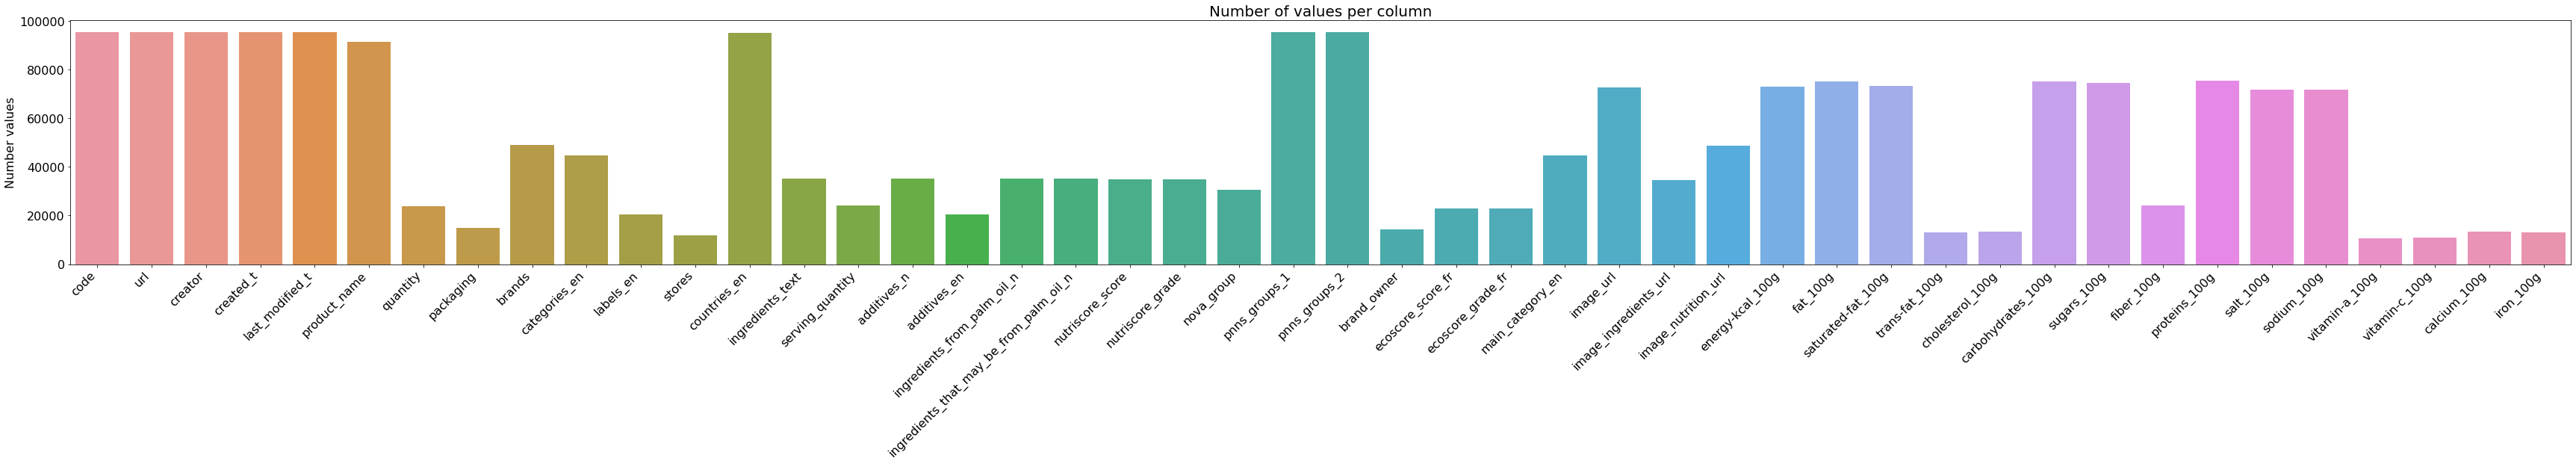

In [73]:
dataframe_distribution_overview(data, figsize=(60, 6))

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 1981 to 1901336
Data columns (total 46 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   code                                     95365 non-null  object 
 1   url                                      95365 non-null  object 
 2   creator                                  95365 non-null  object 
 3   created_t                                95365 non-null  int64  
 4   last_modified_t                          95365 non-null  int64  
 5   product_name                             91372 non-null  object 
 6   quantity                                 23793 non-null  object 
 7   packaging                                14853 non-null  object 
 8   brands                                   48884 non-null  object 
 9   categories_en                            44811 non-null  object 
 10  labels_en                                

In [75]:
data.describe()

,created_t,last_modified_t,serving_quantity,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,nova_group,ecoscore_score_fr,energy-kcal_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g
count,9.536500e+04,9.536500e+04,24210.000000,35186.000000,35186.000000,35186.000000,34763.000000,30672.000000,23036.000000,72977.000000,75230.000000,73144.000000,13213.000000,13443.000000,75204.000000,74420.000000,24055.000000,75320.000000,71713.000000,71713.000000,10569.000000,10954.000000,13514.000000,13209.000000
mean,1.557249e+09,1.591954e+09,100.246087,2.026118,0.020491,0.068038,9.184190,3.439391,43.883183,279.757240,13.828263,5.096298,0.115979,0.067920,28.264047,13.269593,3.032237,8.644599,3.231717,1.292692,0.279910,0.065628,0.190617,0.016719
std,5.182882e+07,3.001842e+07,1290.540542,2.909409,0.144456,0.298788,8.833981,0.954259,26.012479,605.146976,31.427319,8.159680,7.013431,1.700334,28.718327,20.011927,5.089810,10.297124,287.503235,114.995830,15.156190,4.166333,3.550259,1.071768
min,1.331578e+09,1.344769e+09,0.000000,0.000000,0.000000,0.000000,-14.000000,1.000000,-17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.522939e+09,1.581846e+09,28.000000,0.000000,0.000000,0.000000,2.000000,3.000000,27.000000,101.000000,0.700000,0.100000,0.000000,0.000000,3.570000,0.600000,0.000000,1.300000,0.073660,0.029464,0.000000,0.000000,0.000000,0.000000
50%,1.568808e+09,1.593449e+09,50.000000,1.000000,0.000000,0.000000,10.000000,4.000000,38.000000,263.000000,7.000000,1.800000,0.000000,0.000000,15.560000,3.571400,1.600000,6.000000,0.580000,0.232000,0.000000,0.000000,0.036000,0.001010
75%,1.597054e+09,1.615640e+09,113.000000,3.000000,0.000000,0.000000,16.000000,4.000000,65.000000,400.000000,21.430000,7.140000,0.000000,0.020000,53.190000,18.000000,3.600000,12.300000,1.400000,0.560000,0.000107,0.004200,0.108000,0.002480
max,1.628553e+09,1.628553e+09,200000.000000,37.000000,2.000000,5.000000,37.000000,4.000000,125.000000,145000.000000,7000.000000,570.000000,800.000000,77.778000,1200.000000,1050.000000,200.000000,475.000000,75000.000000,30000.000000,950.000000,430.000000,231.000000,120.000000


***
# 4 Categorization

In [76]:
categs = data.select_dtypes(include="object")
categs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 1981 to 1901336
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   code                   95365 non-null  object
 1   url                    95365 non-null  object
 2   creator                95365 non-null  object
 3   product_name           91372 non-null  object
 4   quantity               23793 non-null  object
 5   packaging              14853 non-null  object
 6   brands                 48884 non-null  object
 7   categories_en          44811 non-null  object
 8   labels_en              20362 non-null  object
 9   stores                 11996 non-null  object
 10  countries_en           95084 non-null  object
 11  ingredients_text       35185 non-null  object
 12  additives_en           20397 non-null  object
 13  nutriscore_grade       34763 non-null  object
 14  pnns_groups_1          95355 non-null  object
 15  pnns_groups_2 

In [77]:
categs.drop(columns=["code", "url", "quantity", "nutriscore_grade", "ecoscore_grade_fr", "image_url", "image_ingredients_url", "image_nutrition_url"], inplace=True)
categs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 1981 to 1901336
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   creator           95365 non-null  object
 1   product_name      91372 non-null  object
 2   packaging         14853 non-null  object
 3   brands            48884 non-null  object
 4   categories_en     44811 non-null  object
 5   labels_en         20362 non-null  object
 6   stores            11996 non-null  object
 7   countries_en      95084 non-null  object
 8   ingredients_text  35185 non-null  object
 9   additives_en      20397 non-null  object
 10  pnns_groups_1     95355 non-null  object
 11  pnns_groups_2     95355 non-null  object
 12  brand_owner       14435 non-null  object
 13  main_category_en  44811 non-null  object
dtypes: object(14)
memory usage: 10.9+ MB


/opt/anaconda/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [78]:
def categorize(feature):
    new_feature = feature.astype("category").cat.codes
    return new_feature

In [79]:
categs_to_nums = categs.apply(lambda col: categorize(col))
categs_to_nums

,creator,product_name,packaging,brands,categories_en,labels_en,stores,countries_en,ingredients_text,additives_en,pnns_groups_1,pnns_groups_2,brand_owner,main_category_en
1981,1099,47153,-1,-1,-1,-1,-1,288,-1,-1,11,40,-1,-1
6337,893,63581,-1,16876,2599,-1,-1,672,33159,4971,4,10,-1,2823
131,1099,7067,-1,-1,-1,-1,-1,288,-1,-1,11,40,-1,-1
6805,1099,13953,-1,-1,-1,-1,-1,672,-1,-1,11,40,-1,-1
5054,2136,41361,-1,11344,569,-1,-1,672,23599,1107,1,33,2654,966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1902438,1659,-1,-1,-1,-1,-1,-1,288,-1,-1,11,40,-1,-1
1905426,1099,43971,-1,-1,-1,-1,-1,288,-1,-1,11,40,-1,-1
1904419,1099,42789,-1,-1,-1,-1,-1,288,-1,-1,11,40,-1,-1
1903647,1099,47014,-1,-1,-1,-1,-1,580,-1,-1,11,40,-1,-1


In [80]:
cols = categs_to_nums.columns
cols

Index(['creator', 'product_name', 'packaging', 'brands', 'categories_en', 'labels_en', 'stores', 'countries_en', 'ingredients_text', 'additives_en', 'pnns_groups_1', 'pnns_groups_2', 'brand_owner', 'main_category_en'], dtype='object')

In [81]:
for col in cols:
    categs_to_nums.rename(columns={col: col + "_CATEG"}, inplace=True)

categs_to_nums

,creator_CATEG,product_name_CATEG,packaging_CATEG,brands_CATEG,categories_en_CATEG,labels_en_CATEG,stores_CATEG,countries_en_CATEG,ingredients_text_CATEG,additives_en_CATEG,pnns_groups_1_CATEG,pnns_groups_2_CATEG,brand_owner_CATEG,main_category_en_CATEG
1981,1099,47153,-1,-1,-1,-1,-1,288,-1,-1,11,40,-1,-1
6337,893,63581,-1,16876,2599,-1,-1,672,33159,4971,4,10,-1,2823
131,1099,7067,-1,-1,-1,-1,-1,288,-1,-1,11,40,-1,-1
6805,1099,13953,-1,-1,-1,-1,-1,672,-1,-1,11,40,-1,-1
5054,2136,41361,-1,11344,569,-1,-1,672,23599,1107,1,33,2654,966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1902438,1659,-1,-1,-1,-1,-1,-1,288,-1,-1,11,40,-1,-1
1905426,1099,43971,-1,-1,-1,-1,-1,288,-1,-1,11,40,-1,-1
1904419,1099,42789,-1,-1,-1,-1,-1,288,-1,-1,11,40,-1,-1
1903647,1099,47014,-1,-1,-1,-1,-1,580,-1,-1,11,40,-1,-1


In [82]:
data = data.join([categs_to_nums])

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 1981 to 1901336
Data columns (total 60 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   code                                     95365 non-null  object 
 1   url                                      95365 non-null  object 
 2   creator                                  95365 non-null  object 
 3   created_t                                95365 non-null  int64  
 4   last_modified_t                          95365 non-null  int64  
 5   product_name                             91372 non-null  object 
 6   quantity                                 23793 non-null  object 
 7   packaging                                14853 non-null  object 
 8   brands                                   48884 non-null  object 
 9   categories_en                            44811 non-null  object 
 10  labels_en                                

***
# 5 Global correlations

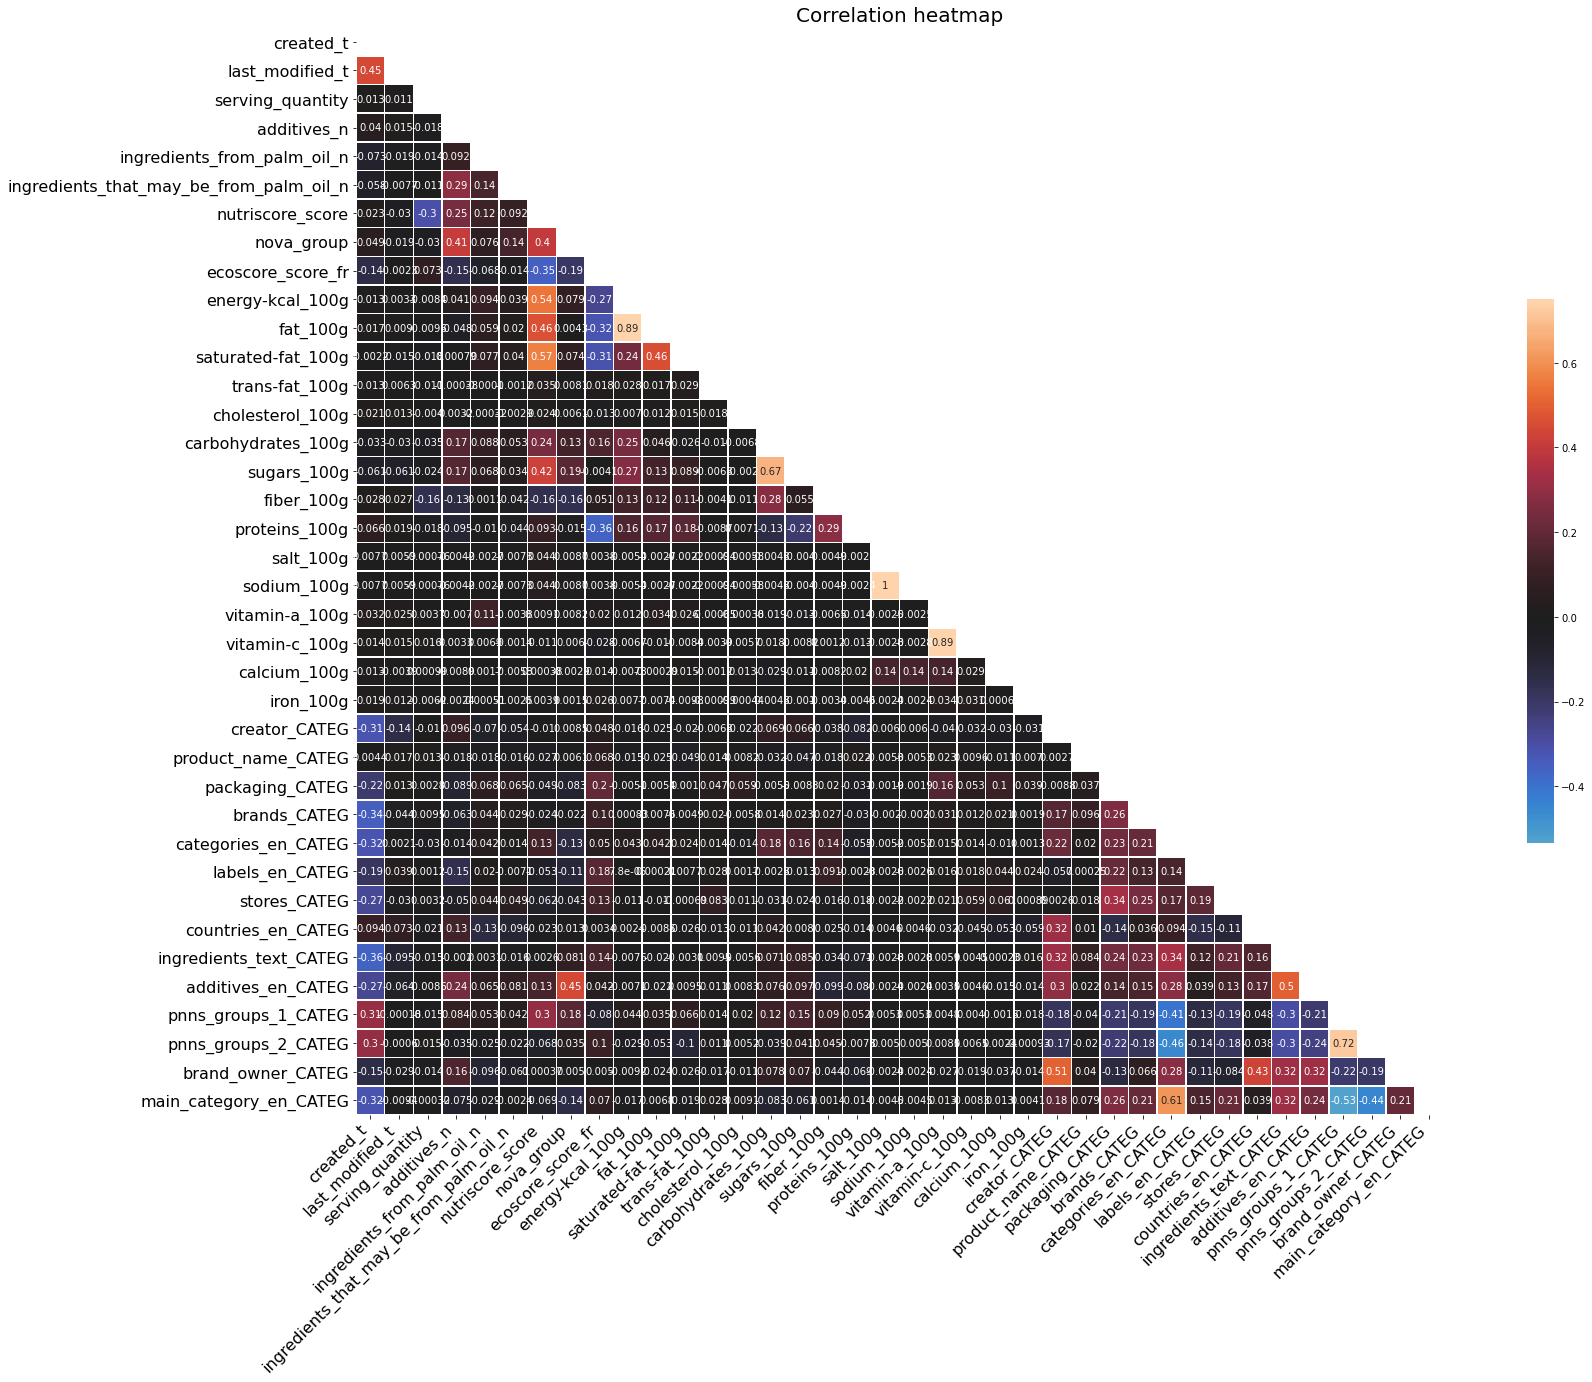

In [84]:
correlation_heatmap(data)

In [85]:
data = data.loc[:, data.columns.difference(data.loc[:, "fat_100g":"iron_100g"].columns)]

In [86]:
data = data.loc[:, data.columns.difference(["created_t", "last_modified_t"])]

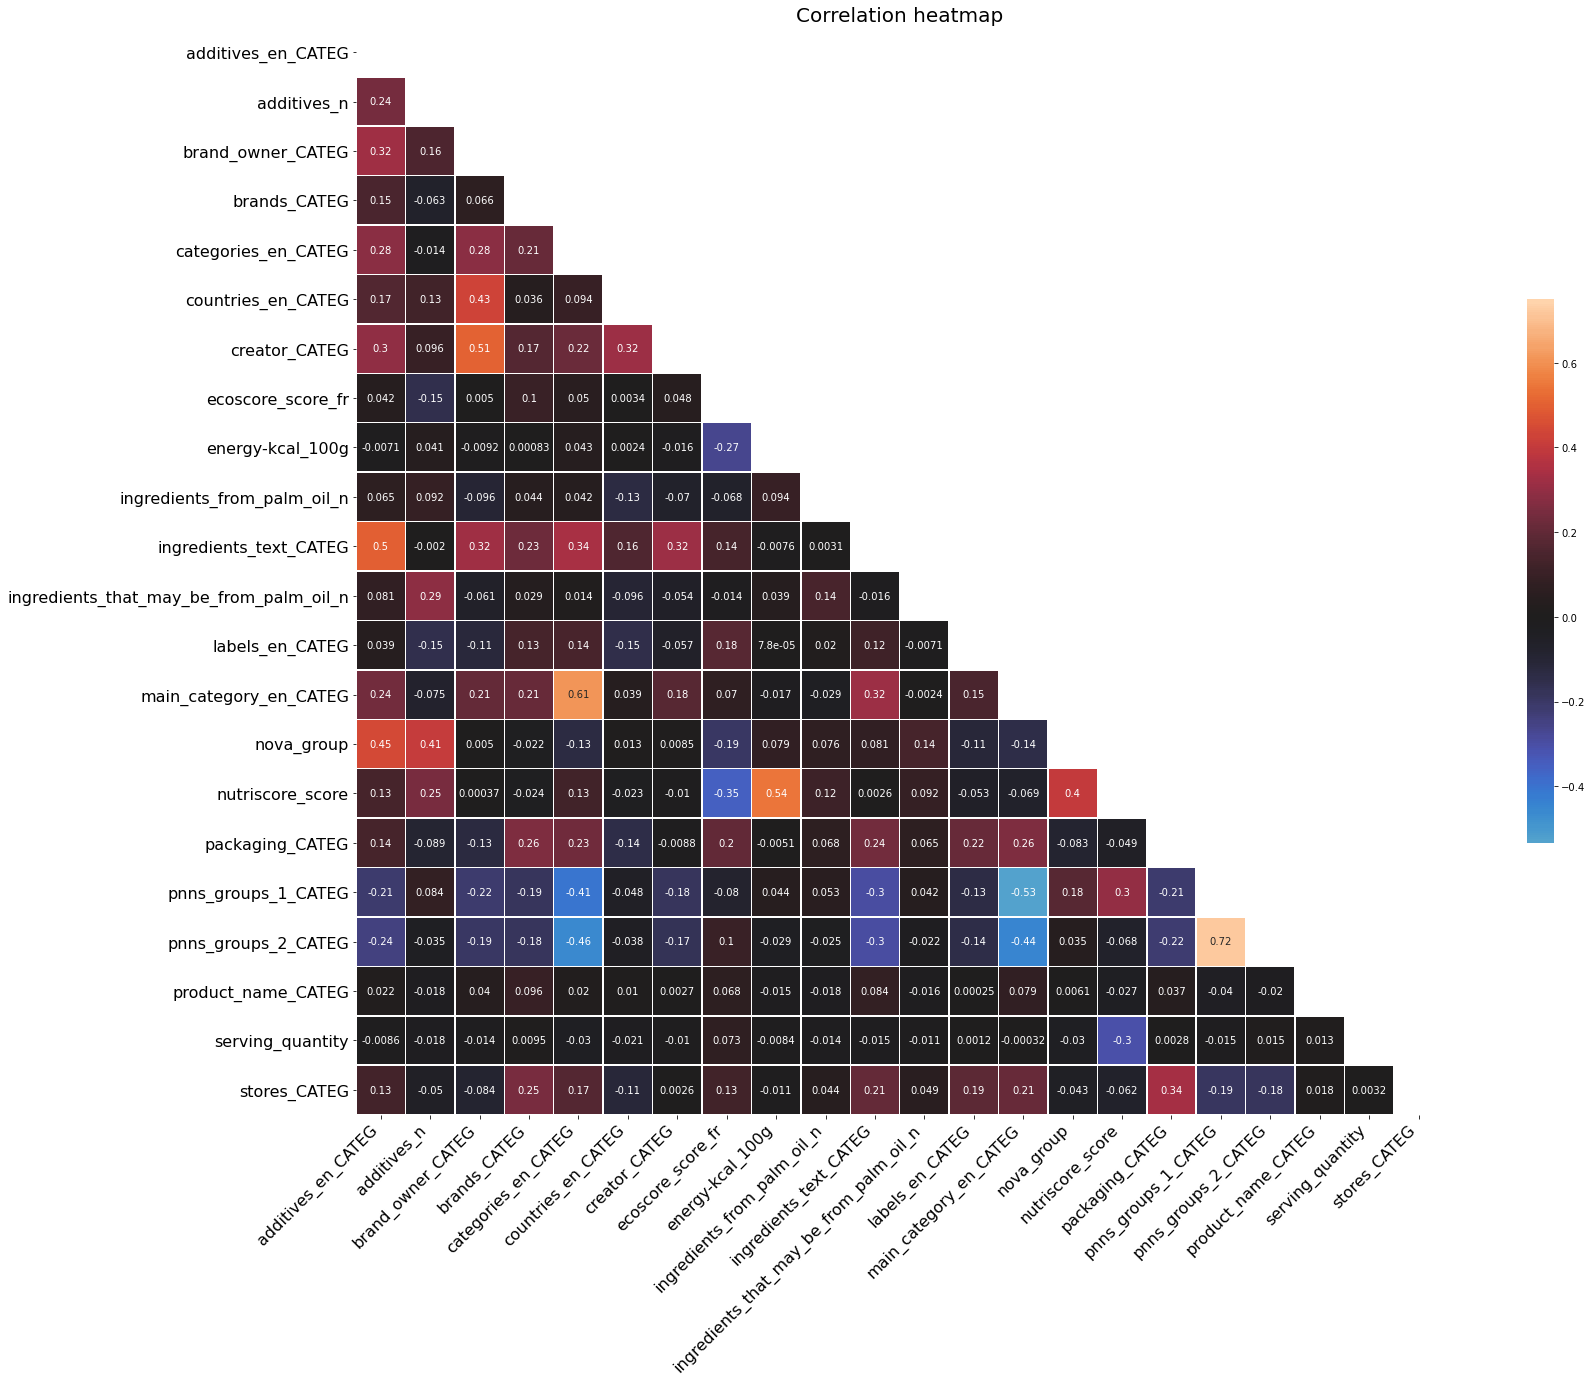

In [87]:
correlation_heatmap(data)

***
# 6 Nutriscore / Ecoscore correlations

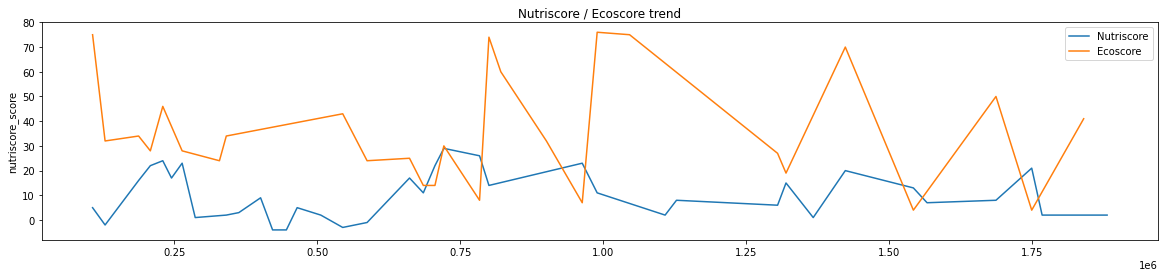

In [19]:
feature_trend_bivar(data, "nutriscore_score", "Nutriscore", "ecoscore_score_fr", "Ecoscore", 1000)

Nutriscore: the bigger the value, the worst the product is.  
Ecoscore: the bigger the value, the worst the environemental impact is.

## Conclusion:
The worst is a product (high nutriscore), the better it is for the environement (low ecoscore).

***
# 7 Nutriscore / Ecoscore distribution

<Figure size 720x432 with 0 Axes>

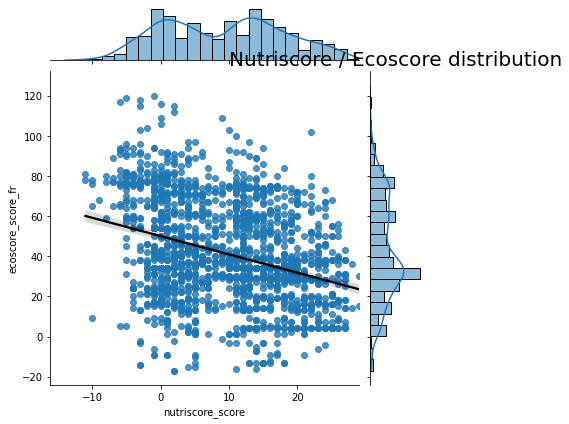

In [20]:
feature_distribution_bivar(data, "nutriscore_score", "Nutriscore", "ecoscore_score_fr", "Ecoscore", divider=10)

***
# 8 Nutriscore / countries disribution

In [21]:
data.iloc[10:].countries_en.head(20)

7944            United States
76                     France
1049            United States
6704            United States
1802                   France
5413            United States
3668                   France
5841            United States
3757    France,United Kingdom
7                      France
6155                   France
5669            United States
206             United States
766                    France
5355                   France
136             United States
7038            United States
7857            United States
8996            United States
1070            United States
Name: countries_en, dtype: object

The feature "countries_en" is in reality a list, as we can see at index 47266: France,United Kingdom.  
We will choose to keep only the last country in this list for each row.

In [22]:
def keep_last_country(row):
    cotr = row["countries_en"]
    splt = cotr.split(",")
    row["countries_en"] = splt[-1]
    return row

data = data[data.countries_en.notna()].apply(lambda row: keep_last_country(row), axis=1)

In [23]:
data.iloc[10:].countries_en.head(20)

76              France
1049     United States
6704     United States
1802            France
5413     United States
3668            France
5841     United States
3757    United Kingdom
7               France
6155            France
5669     United States
206      United States
766             France
5355            France
136      United States
7038     United States
7857     United States
8996     United States
1070     United States
4020     United States
Name: countries_en, dtype: object

Let's see now how the nutriscore is distributed by country.

In [24]:
data_by_countries_nutriscore = data.groupby(["countries_en", "nutriscore_grade"]).nutriscore_grade.agg([len])
data_by_countries_nutriscore.head()

len
countries_en nutriscore_grade     
Algeria      a                   3
             b                   4
             c                   3
             d                   6
             e                   1

In [25]:
data_by_countries_nutriscore = data_by_countries_nutriscore.reset_index()
data_by_countries_nutriscore.head()

,countries_en,nutriscore_grade,len
0,Algeria,a,3
1,Algeria,b,4
2,Algeria,c,3
3,Algeria,d,6
4,Algeria,e,1


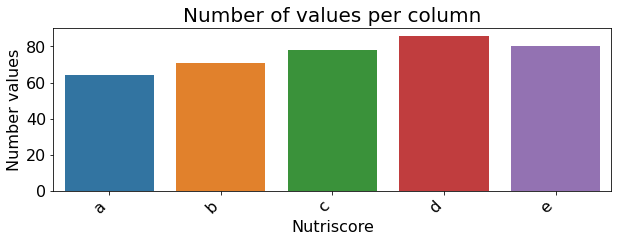

In [26]:
feature_distribution_univar(data_by_countries_nutriscore, "nutriscore_grade", "Nutriscore")

In [27]:
nutriscore_distrib_per_country = data_by_countries_nutriscore.loc[data_by_countries_nutriscore.countries_en.isin(["France", "Germany", "Belgium", "Canada", "Italy", "Mexico", "Netherlands", "Poland", "Portugal", "Spain", "Sweden", "Switzerland", "United Kingdom", "United States"])]

<Figure size 2160x432 with 0 Axes>

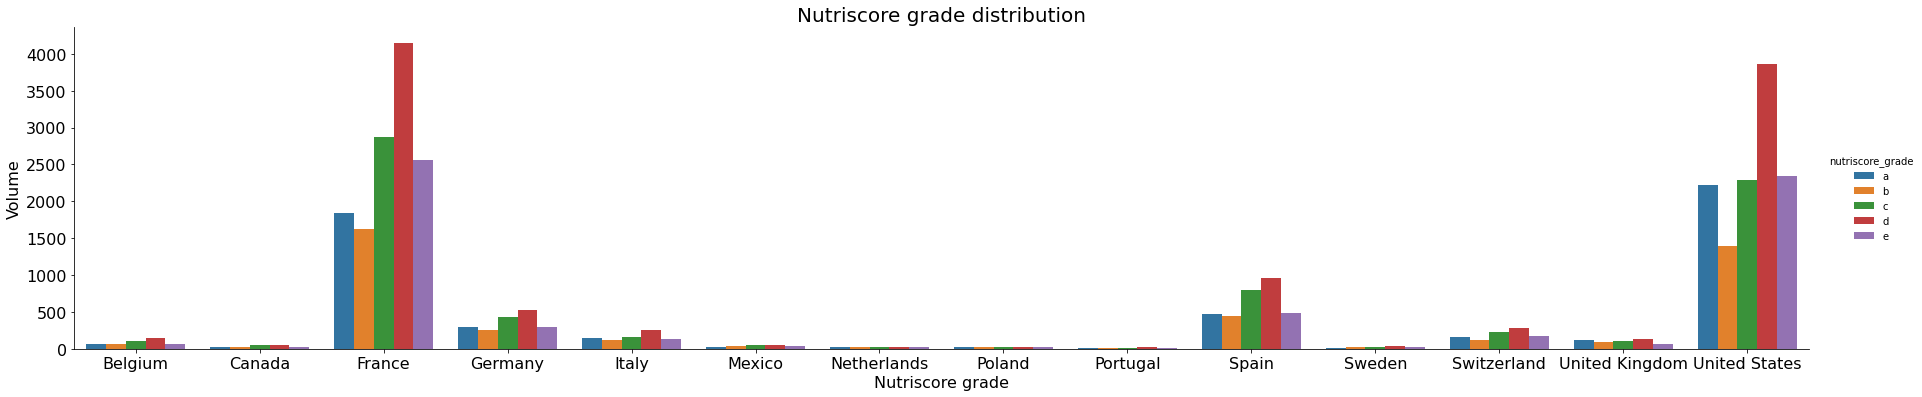

In [28]:
plt.figure(figsize=(30,6))

sns.catplot(x="countries_en", y="len", hue="nutriscore_grade", data=nutriscore_distrib_per_country, kind="bar", height=5, aspect=5)

plt.title("Nutriscore grade distribution", size=20)
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlabel("Nutriscore grade", size=16)
plt.ylabel("Volume", size=16)
plt.show()

***
# 9 Ecoscore / countries distribution

Let's see now how the ecoscore is distributed by country.

In [29]:
data_by_countries_ecoscore = data.groupby(["countries_en", "ecoscore_grade_fr"]).ecoscore_grade_fr.agg([len])
data_by_countries_ecoscore.head()

len
countries_en ecoscore_grade_fr     
Algeria      b                    2
             c                    6
             d                   11
             e                    2
Allemagne    b                    1

In [30]:
data_by_countries_ecoscore = data_by_countries_ecoscore.reset_index()
data_by_countries_ecoscore.head()

,countries_en,ecoscore_grade_fr,len
0,Algeria,b,2
1,Algeria,c,6
2,Algeria,d,11
3,Algeria,e,2
4,Allemagne,b,1


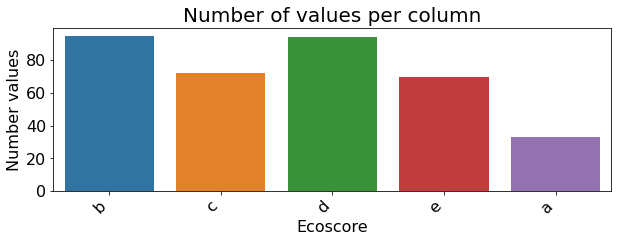

In [31]:
feature_distribution_univar(data_by_countries_ecoscore, "ecoscore_grade_fr", "Ecoscore")

In [32]:
ecoscore_distrib_per_country = data_by_countries_ecoscore.loc[data_by_countries_ecoscore.countries_en.isin(["France", "Germany", "Belgium", "Canad", "Italy", "Mexico", "Netherlands", "Poland", "Portugal", "Spain", "Sweden", "Switzerland", "United Kingdom", "United States"])]

<Figure size 2160x432 with 0 Axes>

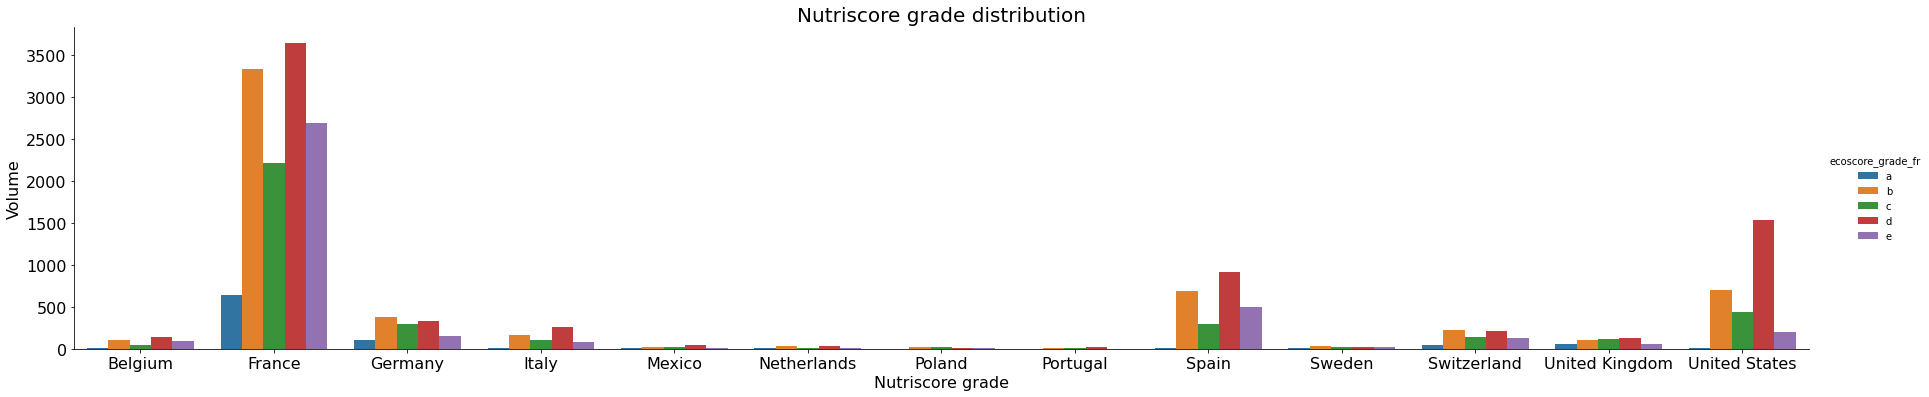

In [33]:
plt.figure(figsize=(30,6))

sns.catplot(x="countries_en", y="len", hue="ecoscore_grade_fr", data=ecoscore_distrib_per_country, kind="bar", height=5, aspect=5)

plt.title("Nutriscore grade distribution", size=20)
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlabel("Nutriscore grade", size=16)
plt.ylabel("Volume", size=16)
plt.show()

***
# ---

## categorical to numerical transformation test

In [34]:
data["ecoscore_CAT"] = data["ecoscore_grade_fr"].astype("category").cat.codes

In [35]:
data["nutriscore_CAT"] = data["nutriscore_grade"].astype("category").cat.codes

In [36]:
data.loc[:, ["ecoscore_CAT", "nutriscore_CAT"]].head()

,ecoscore_CAT,nutriscore_CAT
6413,-1,-1
7973,-1,1
2009,-1,-1
390,-1,-1
7417,-1,-1


## correlation: nutriscore/ecoscore/countries

In [37]:
data["countries_NUM"] = data["countries_en"].astype("category").cat.codes

In [38]:
data.loc[:, ["countries_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,countries_NUM,nutriscore_CAT,ecoscore_CAT
6413,189,-1,-1
7973,189,1,-1
2009,54,-1,-1
390,176,-1,-1
7417,189,-1,-1


In [39]:
data.loc[:, ["countries_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,countries_NUM,nutriscore_CAT,ecoscore_CAT
countries_NUM,1.000000,0.144417,-0.101044
nutriscore_CAT,0.144417,1.000000,0.454549
ecoscore_CAT,-0.101044,0.454549,1.000000


## correlation: nutriscore/ecoscore/brands

In [40]:
data["brands_NUM"] = data["brands"].astype('category').cat.codes

In [41]:
data.loc[:, ["brands_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,brands_NUM,nutriscore_CAT,ecoscore_CAT
6413,16852,-1,-1
7973,6029,1,-1
2009,-1,-1,-1
390,3665,-1,-1
7417,1642,-1,-1


In [42]:
data.loc[:, ["brands_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,brands_NUM,nutriscore_CAT,ecoscore_CAT
brands_NUM,1.000000,0.182362,0.140321
nutriscore_CAT,0.182362,1.000000,0.454549
ecoscore_CAT,0.140321,0.454549,1.000000


## correlation: nutriscore/ecoscore/packaging

In [43]:
data["packaging_NUM"] = data["packaging"].astype("category").cat.codes

In [44]:
data.loc[:, ["packaging_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,packaging_NUM,nutriscore_CAT,ecoscore_CAT
6413,-1,-1,-1
7973,-1,1,-1
2009,-1,-1,-1
390,-1,-1,-1
7417,-1,-1,-1


In [45]:
data.loc[:, ["packaging_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,packaging_NUM,nutriscore_CAT,ecoscore_CAT
packaging_NUM,1.000000,0.163216,0.180140
nutriscore_CAT,0.163216,1.000000,0.454549
ecoscore_CAT,0.180140,0.454549,1.000000


## correlation: nutriscore/ecoscore/categories_en

In [46]:
data["categories_en_NUM"] = data["categories_en"].astype("category").cat.codes

In [47]:
data.loc[:, ["categories_en_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,categories_en_NUM,nutriscore_CAT,ecoscore_CAT
6413,-1,-1,-1
7973,3184,1,-1
2009,-1,-1,-1
390,-1,-1,-1
7417,429,-1,-1


In [48]:
data.loc[:, ["categories_en_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,categories_en_NUM,nutriscore_CAT,ecoscore_CAT
categories_en_NUM,1.000000,0.594528,0.431545
nutriscore_CAT,0.594528,1.000000,0.454549
ecoscore_CAT,0.431545,0.454549,1.000000


## correlation: nutriscore/ecoscore/labels_en

In [49]:
data["labels_en_NUM"] = data["labels_en"].astype("category").cat.codes

In [50]:
data.loc[:, ["labels_en_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,labels_en_NUM,nutriscore_CAT,ecoscore_CAT
6413,-1,-1,-1
7973,-1,1,-1
2009,-1,-1,-1
390,-1,-1,-1
7417,-1,-1,-1


In [51]:
data.loc[:, ["labels_en_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,labels_en_NUM,nutriscore_CAT,ecoscore_CAT
labels_en_NUM,1.000000,0.108814,0.140398
nutriscore_CAT,0.108814,1.000000,0.454549
ecoscore_CAT,0.140398,0.454549,1.000000


## correlation: nutriscore/ecoscore/serving_quantity

In [52]:
data["serving_quantity_NUM"] = data["serving_quantity"].astype("category").cat.codes

In [53]:
data.loc[:, ["serving_quantity_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,serving_quantity_NUM,nutriscore_CAT,ecoscore_CAT
6413,-1,-1,-1
7973,543,1,-1
2009,-1,-1,-1
390,-1,-1,-1
7417,537,-1,-1


In [54]:
data.loc[:, ["serving_quantity_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,serving_quantity_NUM,nutriscore_CAT,ecoscore_CAT
serving_quantity_NUM,1.000000,0.293111,0.006097
nutriscore_CAT,0.293111,1.000000,0.454549
ecoscore_CAT,0.006097,0.454549,1.000000


## correlation: nutriscore/ecoscore/pnns_groups_1/pnns_groups_2

In [55]:
data["pnns_groups_1_NUM"] = data["pnns_groups_1"].astype("category").cat.codes

In [56]:
data["pnns_groups_2_NUM"] = data["pnns_groups_2"].astype("category").cat.codes

In [57]:
data.loc[:, ["pnns_groups_1_NUM", "pnns_groups_2_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,pnns_groups_1_NUM,pnns_groups_2_NUM,nutriscore_CAT,ecoscore_CAT
6413,10,39,-1,-1
7973,3,24,1,-1
2009,10,39,-1,-1
390,10,39,-1,-1
7417,1,33,-1,-1


In [58]:
data.loc[:, ["pnns_groups_1_NUM", "pnns_groups_1_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,pnns_groups_1_NUM,pnns_groups_1_NUM,nutriscore_CAT,ecoscore_CAT
pnns_groups_1_NUM,1.000000,1.000000,-0.388896,-0.397839
pnns_groups_1_NUM,1.000000,1.000000,-0.388896,-0.397839
nutriscore_CAT,-0.388896,-0.388896,1.000000,0.454549
ecoscore_CAT,-0.397839,-0.397839,0.454549,1.000000


## correlation: nutriscore/ecoscore/brand_owner

In [59]:
data["brand_owner_NUM"] = data["brand_owner"].astype("category").cat.codes

In [60]:
data.loc[:, ["brand_owner_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,brand_owner_NUM,nutriscore_CAT,ecoscore_CAT
6413,-1,-1,-1
7973,1359,1,-1
2009,-1,-1,-1
390,-1,-1,-1
7417,4118,-1,-1


In [61]:
data.loc[:, ["brand_owner_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,brand_owner_NUM,nutriscore_CAT,ecoscore_CAT
brand_owner_NUM,1.000000,0.300058,-0.044885
nutriscore_CAT,0.300058,1.000000,0.454549
ecoscore_CAT,-0.044885,0.454549,1.000000


## correlation: nutriscore/ecoscore/nova_group

In [62]:
data["nova_group_NUM"] = data["nova_group"].astype("category").cat.codes

In [63]:
data.loc[:, ["nova_group_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,nova_group_NUM,nutriscore_CAT,ecoscore_CAT
6413,3,-1,-1
7973,3,1,-1
2009,-1,-1,-1
390,-1,-1,-1
7417,3,-1,-1


In [64]:
data.loc[:, ["nova_group_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,nova_group_NUM,nutriscore_CAT,ecoscore_CAT
nova_group_NUM,1.000000,0.489830,0.140752
nutriscore_CAT,0.489830,1.000000,0.454549
ecoscore_CAT,0.140752,0.454549,1.000000


## correlation: nutriscore/ecoscore/additives_en

In [65]:
data["additives_en_NUM"] = data["additives_en"].astype("category").cat.codes

In [66]:
data.loc[:, ["additives_en_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,additives_en_NUM,nutriscore_CAT,ecoscore_CAT
6413,7580,-1,-1
7973,3912,1,-1
2009,-1,-1,-1
390,-1,-1,-1
7417,2028,-1,-1


In [67]:
data.loc[:, ["additives_en_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,additives_en_NUM,nutriscore_CAT,ecoscore_CAT
additives_en_NUM,1.000000,0.350846,0.075472
nutriscore_CAT,0.350846,1.000000,0.454549
ecoscore_CAT,0.075472,0.454549,1.000000


## corr recap

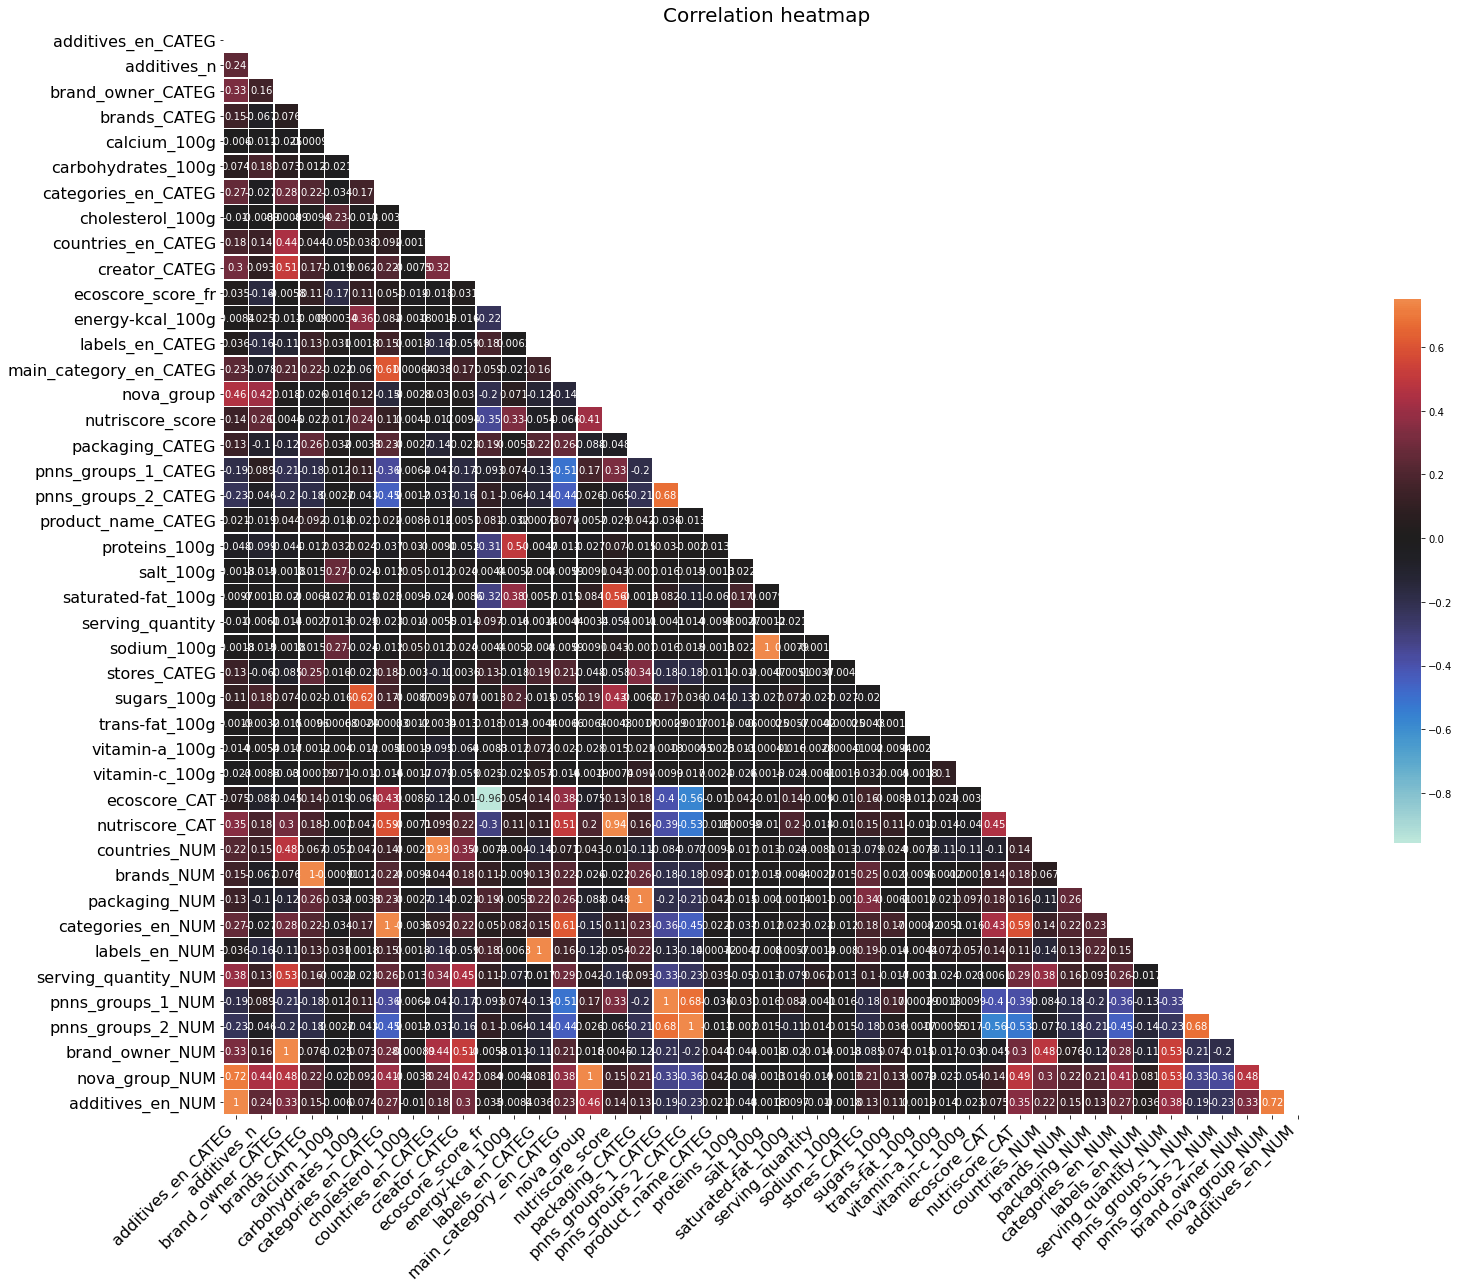

In [68]:
correlation_heatmap(data)

boxplot

La définition des quantiles est correctement maîtrisées.

Les éventuelles valeurs aberrantes ont été mises en évidence. Une solution est proposée (elle doit être justifiée si plusieurs choix sont possibles).

Les distributions observées sont correctement caractérisées (uni, bi, multi-modale).

La définition mathématique de la corrélation et les hypothèses sous-jacentes ont été expliquées
